In [1]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from collections import Counter

import brewer2mpl

# Get "Set2" colors from ColorBrewer (all colorbrewer scales: http://bl.ocks.org/mbostock/5577023)
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift

In [30]:
import hightolowz

In [106]:
redshift = '3p10'
selection = 'mstar9'

In [107]:
dgal_random_r20 = pd.read_csv('data/planck1/dgal_%s_%s_r20_random.csv' % (selection, redshift))
dgal_random_r15 = pd.read_csv('data/planck1/dgal_%s_%s_r15_random.csv' % (selection, redshift))
dgal_random_r10 = pd.read_csv('data/planck1/dgal_%s_%s_r10_random.csv' % (selection, redshift))
dgal_random_r5 = pd.read_csv('data/planck1/dgal_%s_%s_r5_random.csv' % (selection, redshift))

In [108]:
dgal_random = pd.concat([dgal_random_r20,dgal_random_r15,dgal_random_r10,dgal_random_r5], axis=1)

### Probability distribution

For each sampled region if over 50% of the galaxies end up in a cluster sized object at $z=0$ we classify it as a protocluster. We then find the fraction of protoclusters for a range of binned overdensities

In [109]:
limiting_fraction = 0.5


def aggregate_dgal(df, R, bins, lim_frac):
    """
    Aggregate galaxy overdensity information
    """
    
    groups = df.groupby(np.digitize(df['delta_gal_%s' % R], bins))

    agg_data = pd.DataFrame([groups.aggregate(lambda x: \
                            sum((x['max_fraction_%s' % R] > lim_frac) & \
                            (x['max_fraction_mass_%s' % R] > 1e4)))['delta_gal_%s' % R]\
                             / groups.count()['delta_gal_%s' % R], bins]).T

    agg_data.columns = ['frac', 'bins']

    agg_data['frac_lt'] = groups.aggregate(lambda x: \
        sum((x['max_fraction_%s' % R] < lim_frac) & \
        (x['max_fraction_mass_%s' % R] > 1e4)))['delta_gal_%s' % R] \
        / groups.count()['delta_gal_%s' % R]

    agg_data['n_cluster_desc'] = groups.aggregate(lambda x: \
        sum(x[x['max_fraction_%s' % R] < lim_frac]['n_cluster_desc_%s' % R] > 0))['delta_gal_%s' % R] \
        / groups.count()['delta_gal_%s' % R]
    
    return agg_data

Probability distribution and PDF of protocluster regions and non-protocluster regions

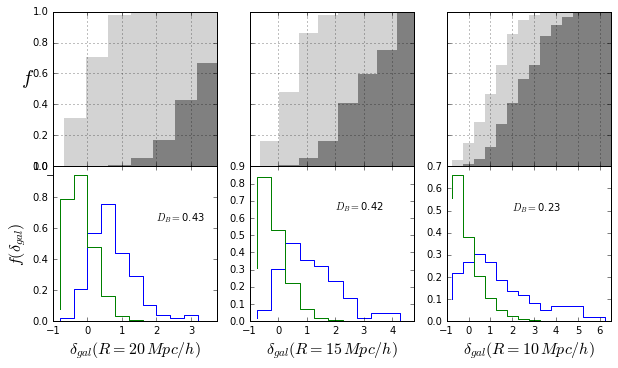

In [115]:
fig = plt.figure(figsize=(10,10))

gs = gridspec.GridSpec(2, 3)

gs.update(bottom = 0.57, top = 1, hspace=0)#, wspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[1,2])


"""
Probability distribution plot
"""

bins = np.linspace(-1, 8, 15)
agg_data = aggregate_dgal(dgal_random, '20', bins, limiting_fraction)

ax1.bar(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], 
        color='grey', width=bins[1]-bins[0], edgecolor='none')

ax1.bar(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['n_cluster_desc'], bottom=agg_data['frac'], 
        color='lightgrey', width=bins[1]-bins[0], edgecolor='none')
#, align='center') # align doesn't work for some reason...

ax1.set_xlabel('$\delta_{gal} (R=20 \, Mpc/h)$', size=16)
ax1.set_ylabel('$f$', size=20, rotation=0)
ax1.grid()

ax1.set_xlim(-1,3.75)
ax4.set_xlim(-1,3.75)

bins = np.linspace(-1, 10, 17)
agg_data = aggregate_dgal(dgal_random, '15', bins, limiting_fraction)

ax2.bar(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], 
        color='grey', width=bins[1]-bins[0], edgecolor='none')

ax2.bar(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['n_cluster_desc'], bottom=agg_data['frac'], 
        color='lightgrey', width=bins[1]-bins[0], edgecolor='none')

ax2.set_xlabel('$\delta_{gal} (R=15 \, Mpc/h)$', size=16)
#ax2.set_ylabel('$f$', size=20)
ax2.grid()
ax2.set_yticklabels('')
ax2.set_xticklabels('')

ax2.set_xlim(-1,4.75)
ax5.set_xlim(-1,4.75)

bins = np.linspace(-1, 8, 19)
agg_data = aggregate_dgal(dgal_random, '10', bins, limiting_fraction)

ax3.bar(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], 
        color='grey', width=bins[1]-bins[0], edgecolor='none')

ax3.bar(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['n_cluster_desc'], bottom=agg_data['frac'], 
        color='lightgrey', width=bins[1]-bins[0], edgecolor='none')

ax3.set_xlabel('$\delta_{gal} (R=10 \, Mpc/h)$', size=16)
#ax3.set_ylabel('$f$', size=20)
ax3.grid()
ax3.set_yticklabels('')
ax3.set_xticklabels('')

ax3.set_xlim(-1,6.5)
ax6.set_xlim(-1,6.5)


"""
PDFs
"""

binLimits = np.linspace(-1, 5, 16)
bins = np.linspace(-0.8, 4.8, 15)

phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_20'] > limiting_fraction) \
                          & (dgal_random['max_fraction_mass_20'] > 1e4)]['delta_gal_20'],
                          bins=binLimits, normed=True)

ax4.step(bins, phiA)

phiB, mass = np.histogram(dgal_random[(dgal_random['max_fraction_20'] < limiting_fraction) \
                          | (dgal_random['max_fraction_mass_20'] < 1e4)]['delta_gal_20'],
                          bins=binLimits, normed=True)

ax4.step(bins, phiB)

DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
ax4.text(2, 0.65, "$D_{B} = $" + str(round(DB, 2)))
ax4.set_xlabel('$\delta_{gal} (R=20 \, Mpc/h)$', size=16)
ax4.set_ylabel('$f(\delta_{gal})$', size=16)



# plot 2
binLimits = np.linspace(-1, 6, 15)
bins = np.linspace(-0.75, 5.75, 14)

phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_20'] > limiting_fraction) \
                          & (dgal_random['max_fraction_mass_20'] > 1e4)]['delta_gal_15'],
                          bins=binLimits, normed=True)

ax5.step(bins, phiA)

phiB, mass = np.histogram(dgal_random[(dgal_random['max_fraction_20'] < limiting_fraction) \
                          | (dgal_random['max_fraction_mass_20'] < 1e4)]['delta_gal_15'],
                          bins=binLimits, normed=True)

ax5.step(bins, phiB)

DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
ax5.text(2, 0.65, "$D_{B} = $" + str(round(DB, 2)))

#ax2.set_yticklabels('')
ax5.set_xlabel('$\delta_{gal} (R=15 \, Mpc/h)$', size=16)



# plot 3
binLimits = np.linspace(-1, 8, 19)
bins = np.linspace(-0.75, 7.75, 18)

#limiting_fraction = 0.6

phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_20'] > limiting_fraction) \
                          & (dgal_random['max_fraction_mass_20'] > 1e4)]['delta_gal_10'],
                          bins=binLimits, normed=True)

ax6.step(bins, phiA)

phiB, mass = np.histogram(dgal_random[(dgal_random['max_fraction_20'] < limiting_fraction) \
                          | (dgal_random['max_fraction_mass_20'] < 1e4)]['delta_gal_10'],
                          bins=binLimits, normed=True)

ax6.step(bins, phiB)

DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
ax6.text(2, 0.5, "$D_{B} = $" + str(round(DB, 2)))

#ax3.set_yticklabels('')
ax6.set_xlabel('$\delta_{gal} (R=10 \, Mpc/h)$', size=16)


#plt.savefig('../../papers/hightolowz/images/gal_od_prob_%s.png' % redshift, bbox_inches='tight', dpi=300)

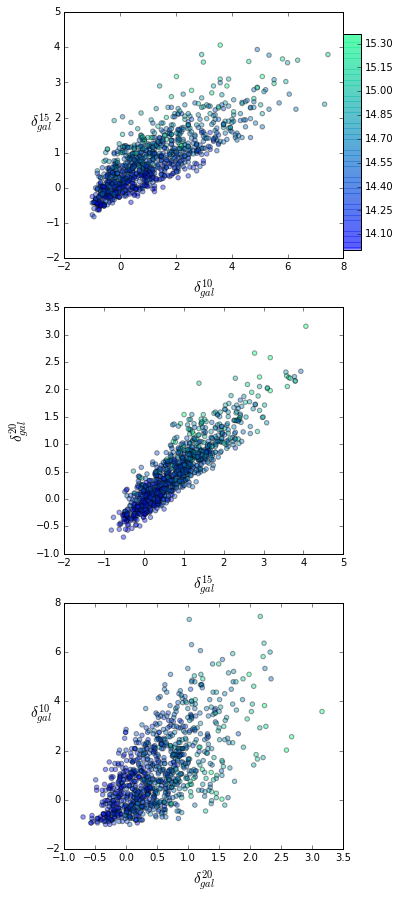

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(5,15))

# plot 1
dgal_temp = dgal_random[(dgal_random['max_fraction_15'] > limiting_fraction) \
                        & (dgal_random['max_fraction_mass_15'] > 1e4)]

p = ax1.scatter(dgal_temp['delta_gal_10'], dgal_temp['delta_gal_15'], alpha=0.4, 
         c=np.log10(dgal_temp['max_fraction_mass_15']*1e10), cmap='winter')

#ax1.axvline(5.5, ls='--', c='grey')
#ax1.axhline(3.75, ls='--', c='grey')

#ax1.set_xlim(-1, 10)
#ax1.set_ylim(-1, 5.5)

ax1.set_xlabel('$\delta_{gal}^{10}$', size=15)
ax1.set_ylabel('$\delta_{gal}^{15}$', rotation=0, size=15)

cax = fig.add_axes([0.9, 0.68, 0.05, 0.2])
fig.colorbar(p, cax=cax, orientation='vertical')


# plot 2

p = ax2.scatter(dgal_temp['delta_gal_15'], dgal_temp['delta_gal_20'], alpha=0.4, 
         c=np.log10(dgal_temp['max_fraction_mass_15']*1e10), cmap='winter')


#ax2.axvline(3.75, ls='--', c='grey')
#ax2.axhline(3.25, ls='--', c='grey')

#ax2.set_xlim(-1, 5.5)
#ax2.set_ylim(-1, 4.5)

ax2.set_xlabel('$\delta_{gal}^{15}$', rotation=0, size=15)
ax2.set_ylabel('$\delta_{gal}^{20}$', size=15)

# cax = fig.add_axes([0.9, 0.48, 0.05, 0.2])
# fig.colorbar(p, cax=cax, orientation='vertical')


# plot 3

p = ax3.scatter(dgal_temp['delta_gal_20'], dgal_temp['delta_gal_10'], alpha=0.4, 
         c=np.log10(dgal_temp['max_fraction_mass_15']*1e10), cmap='winter')

#ax3.axvline(3.25, ls='--', c='grey')
#ax3.axhline(5.5, ls='--', c='grey')

#ax3.set_xlim(-1, 4.5)
#ax3.set_ylim(-1, 9)

ax3.set_xlabel('$\delta_{gal}^{20}$', size=15)
ax3.set_ylabel('$\delta_{gal}^{10}$', rotation=0, size=15)

# cax = fig.add_axes([0.9, 0.68, 0.05, 0.2])
# fig.colorbar(p, cax=cax, orientation='vertical')


# print sum(dgal_temp['delta_gal_10'] > 6)
# print sum(dgal_temp['delta_gal_15'] > 3.5)

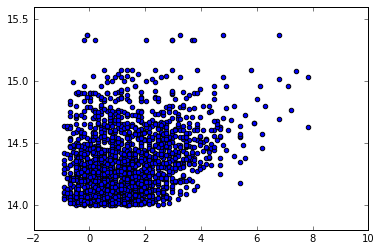

In [152]:
dgal_random = dgal_random_r10

plt.scatter(dgal_random[(dgal_random['max_fraction'] > limiting_fraction) & (dgal_random['max_fraction_mass'] > 1e4)]['delta_gal'],
            np.log10(dgal_random[(dgal_random['max_fraction'] > limiting_fraction) & (dgal_random['max_fraction_mass'] > 1e4)]['max_fraction_mass']*1e10))